### Quick Start

The `LANfactory` package is a light-weight convenience package for training `likelihood approximation networks` (LANs) in torch (or keras), 
starting from supplied training data.

[LANs](https://elifesciences.org/articles/65074), although more general in potential scope of applications, were conceived in the context of sequential sampling modeling
to account for cognitive processes giving rise to *choice* and *reaction time* data in *n-alternative forced choice experiments* commonly encountered in the cognitive sciences.

In this quick tutorial we will use the [`ssms`](https://github.com/AlexanderFengler/ssm_simulators) package to generate our training data using such a sequential sampling model (SSM). The use of of the `LANfactory` package is in no way bound to utilize this `ssms` package.

#### Install

To install the `ssms` package type,

`pip install git+https://github.com/AlexanderFengler/ssm_simulators`

To install the `LANfactory` package type,

`pip install git+https://github.com/AlexanderFengler/LANfactory`

Necessary dependency should be installed automatically in the process.

#### Basic Tutorial

In [1]:
# Load necessary packages
import ssms
import lanfactory 
import os
import numpy as np
from copy import deepcopy
import torch

#### Generate Training Data
First we need to generate some training data. As mentioned above we will do so using the `ssms` python package, however without delving into a detailed explanation
of this package. Please refer to the [basic ssms tutorial] (https://github.com/AlexanderFengler/ssm_simulators) in case you want to learn more.

In [2]:
# MAKE CONFIGS

# Initialize the generator config (for MLP LANs)
generator_config = deepcopy(ssms.config.data_generator_config['lan']['mlp'])
# Specify generative model (one from the list of included models mentioned above)
generator_config['dgp_list'] = 'angle' 
# Specify number of parameter sets to simulate
generator_config['n_parameter_sets'] = 100 
# Specify how many samples a simulation run should entail
generator_config['n_samples'] = 1000
# Specify folder in which to save generated data
generator_config['output_folder'] = 'data/lan_mlp/'

# Make model config dict
model_config = ssms.config.model_config['angle']

In [3]:
# MAKE DATA

my_dataset_generator = ssms.dataset_generators.data_generator(generator_config = generator_config,
                                                              model_config = model_config)

training_data = my_dataset_generator.generate_data_training_uniform(save = True)

n_cpus used:  6
checking:  data/lan_mlp/
simulation round: 1  of 10
simulation round: 2  of 10
simulation round: 3  of 10
simulation round: 4  of 10
simulation round: 5  of 10
simulation round: 6  of 10
simulation round: 7  of 10
simulation round: 8  of 10
simulation round: 9  of 10
simulation round: 10  of 10
Writing to file:  data/lan_mlp/training_data_0_nbins_0_n_1000/angle/training_data_angle_ef5b9e0eb76c11eca684acde48001122.pickle


#### Prepare for Training

Next we set up dataloaders for training with pytorch. The `LANfactory` uses custom dataloaders, taking into account particularities of the expected training data.
Specifically, we expect to receive a bunch of training data files (the present example generates only one), where each file hosts a large number of training examples. 
So we want to define a dataloader which spits out batches from data with a specific training data file, and keeps checking when to load in a new file. 
The way this is implemented here, is via the `DatasetTorch` class in `lanfactory.trainers`, which inherits from `torch.utils.data.Dataset` and prespecifies a `batch_size`. Finally this is supplied to a [`DataLoader`](https://pytorch.org/docs/stable/data.html), for which we keep the `batch_size` argument at 0.

The `DatasetTorch` class is then called as an iterator via the DataLoader and takes care of batching as well as file loading internally. 

You may choose your own way of defining the `DataLoader` classes, downstream you are simply expected to supply one.

In [4]:
# MAKE DATALOADERS

# List of datafiles (here only one)
folder_ = 'data/lan_mlp/training_data_0_nbins_0_n_1000/angle/'
file_list_ = [folder_ + file_ for file_ in os.listdir(folder_)]

# Training dataset
torch_training_dataset = lanfactory.trainers.DatasetTorch(file_IDs = file_list_,
                                                          batch_size = 128)

torch_training_dataloader = torch.utils.data.DataLoader(torch_training_dataset,
                                                         shuffle = True,
                                                         batch_size = None,
                                                         num_workers = 1,
                                                         pin_memory = True)

# Validation dataset
torch_validation_dataset = lanfactory.trainers.DatasetTorch(file_IDs = file_list_,
                                                          batch_size = 128)

torch_validation_dataloader = torch.utils.data.DataLoader(torch_validation_dataset,
                                                          shuffle = True,
                                                          batch_size = None,
                                                          num_workers = 1,
                                                          pin_memory = True)

Now we define two configuration dictionariers,

1. The `network_config` dictionary defines the architecture and properties of the network
2. The `train_config` dictionary defines properties concerning training hyperparameters

Two examples (which we take as provided by the package, but which you can adjust according to your needs) are provided below.

In [5]:
# SPECIFY NETWORK CONFIGS AND TRAINING CONFIGS

network_config = lanfactory.config.network_configs.network_config_mlp

print('Network config: ')
print(network_config)

train_config = lanfactory.config.network_configs.train_config_mlp

print('Train config: ')
print(train_config)

Network config: 
{'layer_types': ['dense', 'dense', 'dense'], 'layer_sizes': [100, 100, 1], 'activations': ['tanh', 'tanh', 'linear'], 'loss': ['huber'], 'callbacks': ['checkpoint', 'earlystopping', 'reducelr']}
Train config: 
{'batch_size': 128, 'n_epochs': 10, 'optimizer': 'adam', 'learning_rate': 0.002, 'loss': 'huber', 'save_history': True, 'metrics': [<keras.losses.MeanSquaredError object at 0x12c403d30>, <keras.losses.Huber object at 0x12c1c78e0>], 'callbacks': ['checkpoint', 'earlystopping', 'reducelr']}


We can now load a network, and save the configuration files for convenience.

In [6]:
# LOAD NETWORK
net = lanfactory.trainers.TorchMLP(network_config = deepcopy(network_config),
                                   input_shape = torch_training_dataset.input_dim,
                                   save_folder = '/data/torch_models/',
                                   generative_model_id = 'angle')

# SAVE CONFIGS
lanfactory.utils.save_configs(model_id = net.model_id + '_torch_',
                              save_folder = 'data/torch_models/angle/', 
                              network_config = network_config, 
                              train_config = train_config, 
                              allow_abs_path_folder_generation = True)

tanh
linear


To finally train the network we supply our network, the dataloaders and training config to the `ModelTrainerTorchMLP` class, from `lanfactory.trainers`.

In [9]:
# TRAIN MODEL
model_trainer.train_model(save_history = True,
                          save_model = True,
                          verbose = 0)

Epoch took 0 / 10,  took 11.54538607597351 seconds
epoch 0 / 10, validation_loss: 0.3431
Epoch took 1 / 10,  took 13.032279014587402 seconds
epoch 1 / 10, validation_loss: 0.2732
Epoch took 2 / 10,  took 12.421074867248535 seconds
epoch 2 / 10, validation_loss: 0.1941
Epoch took 3 / 10,  took 12.097641229629517 seconds
epoch 3 / 10, validation_loss: 0.2028
Epoch took 4 / 10,  took 12.030233144760132 seconds
epoch 4 / 10, validation_loss: 0.184
Epoch took 5 / 10,  took 12.695374011993408 seconds
epoch 5 / 10, validation_loss: 0.1433
Epoch took 6 / 10,  took 12.177874326705933 seconds
epoch 6 / 10, validation_loss: 0.1115
Epoch took 7 / 10,  took 11.908828258514404 seconds
epoch 7 / 10, validation_loss: 0.1084
Epoch took 8 / 10,  took 12.066670179367065 seconds
epoch 8 / 10, validation_loss: 0.0864
Epoch took 9 / 10,  took 12.37562108039856 seconds
epoch 9 / 10, validation_loss: 0.07484
Saving training history
Saving model state dict
Training finished successfully...


#### Load Model for Inference and Call

The `LANfactory` provides some convenience functions to use networks for inference after training. 
We can load a model using the `LoadTorchMLPInfer` class, which then allows us to run fast inference via either
a direct call, which expects a `torch.tensor` as input, or the `predict_on_batch` method, which expects a `numpy.array` 
of `dtype`, `np.float32`. 

In [10]:
network_path_list = os.listdir('data/torch_models/angle')
network_file_path = ['data/torch_models/angle/' + file_ for file_ in network_path_list if 'state_dict' in file_][0]

network = lanfactory.trainers.LoadTorchMLPInfer(model_file_path = network_file_path,
                                                network_config = network_config,
                                                input_dim = torch_training_dataset.input_dim)

tanh
linear


In [14]:
# Two ways to call the network

# Direct call --> need tensor input
direct_out = network(torch.from_numpy(np.array([1, 1.5, 0.5, 1.0, 0.1, 0.65, 1], dtype  = np.float32)))
print('direct call out: ', direct_out)

# predict_on_batch method
predict_on_batch_out = network.predict_on_batch(np.array([1, 1.5, 0.5, 1.0, 0.1, 0.65, 1], dtype  = np.float32))
print('predict_on_batch out: ', predict_on_batch_out)


direct call out:  tensor([-16.4997])
predict_on_batch out:  [-16.499687]


#### A peek into the first passage distribution computed by the network

We can compare the learned likelihood function in our `network` with simulation data from the underlying generative model.
For this purpose we recruit the [`ssms`](https://github.com/AlexanderFengler/ssm_simulators) package again.

In [40]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.DataFrame(np.zeros((2000, 7), dtype = np.float32), columns = ['v', 'a', 'z', 't', 'theta', 'rt', 'choice'])
data['v'] = 0.5
data['a'] = 0.75
data['z'] = 0.5
data['t'] = 0.2
data['theta'] = 0.1
data['rt'].iloc[:1000] = np.linspace(5, 0, 1000)
data['rt'].iloc[1000:] = np.linspace(0, 5, 1000)
data['choice'].iloc[:1000] = -1
data['choice'].iloc[1000:] = 1

# Network predictions
predict_on_batch_out = network.predict_on_batch(data.values.astype(np.float32))

# Simulations
from ssms.basic_simulators import simulator
sim_out = simulator(model = 'angle', 
                    theta = data.values[0, :-2],
                    n_samples = 2000)

Text(0, 0.5, 'likelihod')

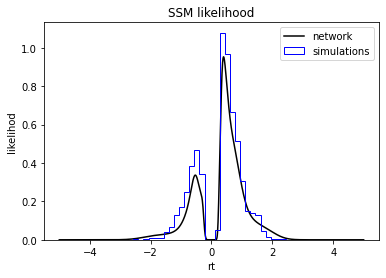

In [56]:
# Plot network predictions
plt.plot(data['rt'] * data['choice'], np.exp(predict_on_batch_out), color = 'black', label = 'network')

# Plot simulations
plt.hist(sim_out['rts'] * sim_out['choices'], bins = 30, histtype = 'step', label = 'simulations', color = 'blue', density  = True)
plt.legend()
plt.title('SSM likelihood')
plt.xlabel('rt')
plt.ylabel('likelihod')

We hope this package may be helpful in case you attempt to train [LANs](https://elifesciences.org/articles/65074) for your own research.

#### END